# **Spotify Music Recommendation**

## **Team 2**

## Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import sys
import itertools
import warnings
warnings.filterwarnings("ignore")

#Visual
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#Spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import spotipy.util as util

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## 1. Data Exploration/Preparation

In [2]:
data = pd.read_csv('https://fabriziorocco.it/data.csv')
#If download doesn't work try to download the compressed dataset from github
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [3]:
data_genre = pd.read_csv('https://fabriziorocco.it/data_gen.csv')
#If download doesn't work try to download the dataset from github
data_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [4]:
data_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

This checks whether or not `genres` is actually in a list format:

In [5]:
data_genre['genres'].values[0]

"['show tunes']"

In [6]:
#To check if this is actually a list
data_genre['genres'].values[0][0]

'['

Regex statement to extract the genre and input into a list

In [7]:
data_genre['genres_upd'] = data_genre['genres'].apply(lambda x: [re.sub(' ', '_', i) for i in re.findall(r"'([^']*)'", x)])
data_genre['genres_upd'].values[0][0]

'show_tunes'

Genre column ok. 

Next Steps:
1. Explode artists column
2. Merge `data_w_genre` to the exploded dataset in Step 1

Step 1. 
Extract the artists from the string list. 

In [8]:
data['artists1'] = data['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))
data['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [9]:
data['artists1'].values[0][0]

'Sergei Rachmaninoff'

This looks good but did this work for every artist string format. Let's double check

In [10]:
data[data['artists1'].apply(lambda x: not x)].head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists1
143,0.300,1921,0.772,"[""Scarlet D'Carpio""]",0.560,249370,0.313,0,7b4eHImKQ51DYaQvNTdtEp,0.000005,6,0.115,-8.346,0,Himno Nacional del Perú,0,1921-09-23,0.0376,107.501,[]
234,0.902,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.708,194533,0.361,0,1xEEYhWxT4WhDQdxfPCT8D,0.883000,0,0.103,-11.764,0,Snake Rag,20,1923,0.0441,105.695,[]
238,0.554,1923,0.996,"[""King Oliver's Creole Jazz Band""]",0.546,170827,0.189,0,3rauXVLOOM5BlxWqUcDpkg,0.908000,0,0.339,-15.984,1,Chimes Blues,13,1923,0.0581,80.318,[]
244,0.319,1923,0.995,"[""Clarence Williams' Blue Five""]",0.520,197493,0.153,0,1UdqHVRFYMZKU2Q7xkLtYc,0.131000,0,0.353,-14.042,1,Pickin' On Your Baby,11,1923,0.0440,102.937,[]
249,0.753,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.359,187227,0.357,0,5SvyP1ZeJX1jA7AOZD08NA,0.819000,3,0.290,-11.810,1,Tears,10,1923,0.0511,205.053,[]


Problem with artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. 

Regex 2

In [11]:
data['artists2'] = data['artists'].apply(lambda x: re.findall('\"(.*?)\"', x))
data['artists_upd'] = np.where(data['artists1'].apply(lambda x: not x), data['artists2'], data['artists1'])

In [12]:
#Create a Custom Song Identifier
data['artists_song'] = data.apply(lambda row: row['artists_upd'][0] + row['name'], axis = 1)
#Sorting
data.sort_values(['artists_song', 'release_date'], ascending = False, inplace = True)

In [13]:
data.drop_duplicates('artists_song', inplace = True)

Now I can explode this column and merge as I planned to in `Step 2`

In [14]:
artists_exploded = data[['artists_upd', 'id']].explode('artists_upd')

In [15]:
artists_exploded.tail()

,artists_upd,id
15465,"Dirty Bastard"",",6YYd5MLpu45J0uLrMdivF7
15465,",",6YYd5MLpu45J0uLrMdivF7
103581,"Cru"", ""Michel",3hoiinUc5VA9xUEJID7R8V
150996,"4-Tay"",",78859Af0fmA9VTlgnOHTAP
150996,",",78859Af0fmA9VTlgnOHTAP


First merge on left the genre dataset and then remove nans

In [16]:
artists_exploded_new = artists_exploded.merge(data_genre, how ='left', left_on ='artists_upd', right_on ='artists')
artists_exploded_new_nonans = artists_exploded_new[~artists_exploded_new.genres_upd.isnull()]

Now we have a dataset with artists cleaned + id + the corresponding genre + features

Alright we're almost their, now we need to:
1. Group by on the song `id` to create lists
2. Consolidate and output the unique values

In [17]:
#Function below taken from https://stackoverflow.com/questions/50775024/itertools-chain-from-iterable/50775088

In [18]:
genres_cons = artists_exploded_new_nonans.groupby('id')['genres_upd'].apply(list).reset_index()
genres_cons['consolidates_genre_lists'] = genres_cons['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))
genres_cons.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[candy_pop, permanent_wave, dance_rock, rock, ..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn...","[minnesota_hip_hop, pop_rap, conscious_hip_hop..."
2,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[ghazal, sufi, classic_bollywood, classic_paki..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[piano_blues, ragtime, stride, boogie-woogie]"
4,000jBcNljWTnyjB4YO7ojf,[[]],[]


In [19]:
#Merge dataframe
data = data.merge(genres_cons[['id', 'consolidates_genre_lists']], on ='id', how ='left')
data.tail()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists1,artists2,artists_upd,artists_song,consolidates_genre_lists
156602,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.693,0,2LP2uDQQ7eLMcUVE4aOpAV,0.00000,11,0.123,-7.832,0,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R...",NaN
156603,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.387,1,4s0o8TJHfX9LLHa0umnOzT,0.00000,0,0.131,-9.867,1,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
156604,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.459,1,6YYd5MLpu45J0uLrMdivF7,0.00000,1,0.222,-7.654,1,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)",NaN
156605,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.490,0,3hoiinUc5VA9xUEJID7R8V,0.00017,9,0.139,-9.504,0,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
156606,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.414,1,78859Af0fmA9VTlgnOHTAP,0.00011,4,0.101,-8.450,0,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


## 2. Processing and Feature Engineering

In [20]:
data['year'] = data['release_date'].apply(lambda x: x.split('-')[0])
float_cols = data.dtypes[data.dtypes == 'float64'].index.values

In [21]:
#Popularity encoding
ohe_cols = 'popularity'
# create 5 point buckets for popularity. DI
data['popularity_red'] = data['popularity'].apply(lambda x: int(x / 5))

In [22]:
#Convert NaNs in empty lists
data['consolidates_genre_lists'] = data['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [23]:
#Custom function to create dummy columns. It provides also preparation for tfidf
def one_hot_encoding(df, column, new_name):
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [24]:
#Custom function to build entire feature set
def create_feature_set(df, float_cols):
    #Term frequency inverse document frequency and OHE
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)
    year_ohe = one_hot_encoding(df, 'year','year') * 0.5
    popularity_ohe = one_hot_encoding(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [25]:
complete_feature_set = create_feature_set(data, float_cols=float_cols)
complete_feature_set.tail()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
156602                           0.0          0.0             0.0   
156603                           0.0          0.0             0.0   
156604                           0.0          0.0             0.0   
156605                           0.0          0.0             0.0   
156606                           0.0          0.0             0.0   

        genre|a_cappella  genre|abstract  genre|abstract_beats  \
156602               0.0             0.0                   0.0   
156603               0.0             0.0                   0.0   
156604               0.0             0.0                   0.0   
156605               0.0             0.0                   0.0   
156606               0.0             0.0                   0.0   

        genre|abstract_hip_hop  genre|accordeon  genre|accordion  \
156602                     0.0              0.0              0.0   
156603                     0.0              0.0              0.0   
156604                     0.0              0.0              0.0   
156605                     0.0              0.0              0.0   
156606                     0.0              0.0              0.0   

        genre|acid_house  genre|acid_rock  genre|acid_trance  \
156602               0.0              0.0                0.0   
156603               0.0              0.0                0.0   
156604               0.0              0.0                0.0   
156605               0.0              0.0                0.0   
156606               0.0              0.0                0.0   

        genre|acousmatic  genre|acoustic  genre|acoustic_blues  \
156602               0.0             0.0                   0.0   
156603               0.0             0.0                   0.0   
156604               0.0             0.0                   0.0   
156605               0.0             0.0                   0.0   
156606               0.0             0.0                   0.0   

        genre|acoustic_pop  genre|acoustic_punk  genre|acoustic_rock  \
156602                 0.0                  0.0                  0.0   
156603                 0.0                  0.0                  0.0   
156604                 0.0                  0.0                  0.0   
156605                 0.0                  0.0                  0.0   
156606                 0.0                  0.0                  0.0   

        genre|action_rock  genre|adoracion  genre|adult_standards  \
156602                0.0              0.0                    0.0   
156603                0.0              0.0                    0.0   
156604                0.0              0.0                    0.0   
156605                0.0              0.0                    0.0   
156606                0.0              0.0                    0.0   

        genre|adventista  genre|afghan_pop  genre|afghan_traditional  \
156602               0.0               0.0                       0.0   
156603               0.0               0.0                       0.0   
156604               0.0               0.0                       0.0   
156605               0.0               0.0                       0.0   
156606               0.0               0.0                       0.0   

        genre|african  genre|african_percussion  genre|african_reggae  \
156602            0.0                       0.0                   0.0   
156603            0.0                       0.0                   0.0   
156604            0.0                       0.0                   0.0   
156605            0.0                       0.0                   0.0   
156606            0.0                       0.0                   0.0   

        genre|african_rock  genre|afro  genre|afro_dancehall  \
156602                 0.0         0.0                   0.0   
156603                 0.0         0.0                   0.0   
156604                 0.0         0.0                   0.0   
156605                 0.0   

## 3. Spotipy

In [26]:
client_id = '1659166c086249a09f1dedffe685d4a3'
client_secret= 'd4aa95e596574ac3aa0b6de9270d2990'

In [27]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [28]:
#Auth to connect
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')
sp = spotipy.Spotify(auth=token)

In [29]:
#Gather playlist names and images. 
id_name = {}
list_photo = {}
try:
    for i in sp.current_user_playlists(limit=5)['items']:
        id_name[i['name']] = i['uri'].split(':')[2]
        list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']
except:
    print("Check that all your playlists have an image")

In [30]:
def create_necessary_outputs(playlist_name,id_dic, df):
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    playlist = playlist.iloc[:15]
    
    return playlist

In [31]:
test_playlist = create_necessary_outputs('EDM TOP HITS - Best Eletro Festival Dance Avicii David Guetta Calvin Harris Martin Garrix Hardwell', id_name, data)

In [32]:
#The following code is taken from matplotlib official docs and then customized on lines 5 and 9

In [33]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, i + 1)
        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

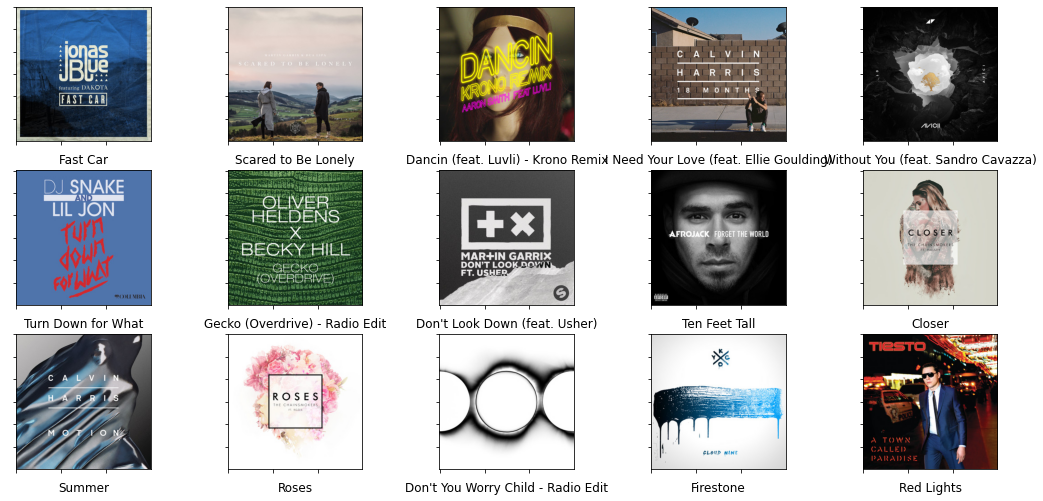

In [34]:
visualize_songs(test_playlist)

## 4. Create Playlist Vector

In [35]:
def generate_playlist_feature(complete_feature_set, playlist_df, recency_bias):

    #This function's aim is to summarize the user's playlist into a unidimensional vector. In this way it's easy to compare it with the spotify playlist.
    #It takes as argument:
    # - the feature set
    # - user's playlist
    # - Recency biased
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
    #This function has been taken from Stack Exchange: https://codereview.stackexchange.com/questions/233698/python-code-for-list-of-month-names-starting-with-current-month
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: recency_bias ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [36]:
playlist_vector_test, feature_set_nonplaylist_test = generate_playlist_feature(complete_feature_set, test_playlist, 1.09)
#Recency bias is a value to give more weight to the most recent added songs

## 5. Generate Recommendations

In [37]:
def generate_rec(df, features, nonplaylist_features):
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    t30 = non_playlist_df.sort_values('sim',ascending = False).head(30)
    t30['url'] = t30['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return t30

In [38]:
test_top30 = generate_rec(data, playlist_vector_test, feature_set_nonplaylist_test)
test_top30

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists1,artists2,artists_upd,artists_song,consolidates_genre_lists,popularity_red,sim,url
107391,0.5450,2015,0.001040,['Galantis'],0.708,203133,0.945,0,3aIhJDHxr1kgTSnutJxPTH,0.080300,5,0.2270,-3.247,0,Peanut Butter Jelly,65,2015-06-05,0.2340,127.960,[Galantis],[],[Galantis],GalantisPeanut Butter Jelly,"[tropical_house, pop, edm, big_room, pop_dance...",13,0.802536,https://i.scdn.co/image/ab67616d00001e022b5179...
107390,0.3830,2015,0.007110,['Galantis'],0.506,227074,0.805,0,46lFttIf5hnUZMGvjK0Wxo,0.001930,1,0.0856,-4.119,1,Runaway (U & I),75,2015-06-05,0.0469,126.008,[Galantis],[],[Galantis],GalantisRunaway (U & I),"[tropical_house, pop, edm, big_room, pop_dance...",15,0.794956,https://i.scdn.co/image/ab67616d00001e022b5179...
65450,0.3000,2015,0.050000,['Martin Garrix'],0.534,230635,0.711,0,6EsH66Uto1zwZlDGQ6RokU,0.003100,10,0.1350,-5.927,0,Forbidden Voices,64,2015-02-23,0.0368,128.102,[Martin Garrix],[],[Martin Garrix],Martin GarrixForbidden Voices,"[tropical_house, pop, edm, big_room, pop_dance...",12,0.792905,https://i.scdn.co/image/ab67616d00001e025a68d0...
126659,0.5680,2014,0.093200,"['David Guetta', 'Sam Martin']",0.645,203520,0.891,0,2i2zYdN4KCkTCDscdMYr87,0.000004,6,0.3790,-2.505,0,Lovers on the Sun (feat. Sam Martin),48,2014-11-24,0.0387,124.915,"[David Guetta, Sam Martin]",[],"[David Guetta, Sam Martin]",David GuettaLovers on the Sun (feat. Sam Martin),"[tropical_house, pop, edm, pop_dance, dance_pop]",9,0.782890,https://i.scdn.co/image/ab67616d00001e0222f21e...
107392,0.7800,2017,0.028200,['Galantis'],0.674,191293,0.915,0,6M6Tk58pQvABy6ru66dY3d,0.003370,6,0.2730,-3.999,0,No Money,70,2017-09-15,0.0411,126.038,[Galantis],[],[Galantis],GalantisNo Money,"[tropical_house, pop, edm, big_room, pop_dance...",14,0.782380,https://i.scdn.co/image/ab67616d00001e0271340c...
126667,0.4300,2014,0.417000,"['David Guetta', 'Sam Martin']",0.466,203641,0.747,0,2w2lfwoTELQyN940qM7Nfd,0.000010,4,0.1070,-4.838,0,Dangerous (feat. Sam Martin),49,2014-11-24,0.0795,92.161,"[David Guetta, Sam Martin]",[],"[David Guetta, Sam Martin]",David GuettaDangerous (feat. Sam Martin),"[tropical_house, pop, edm, pop_dance, dance_pop]",9,0.773295,https://i.scdn.co/image/ab67616d00001e0222f21e...
65453,0.0381,2016,0.001370,['Martin Garrix'],0.593,176120,0.914,0,65G7XDGcybJiGywSCXJiL5,0.445000,1,0.0714,-5.351,1,Animals - Radio Edit,57,2016-12-16,0.0363,128.015,[Martin Garrix],[],[Martin Garrix],Martin GarrixAnimals - Radio Edit,"[tropical_house, pop, edm, big_room, pop_dance...",11,0.769530,https://i.scdn.co/image/ab67616d00001e02a8bbff...
152847,0.4980,2015,0.036500,"['Alesso', 'Roy English']",0.537,221400,0.848,0,2ToIksTPpJ4csKPEOdUEyM,0.000000,6,0.4230,-2.431,0,Cool,58,2015-05-26,0.0313,128.023,"[Alesso, Roy English]",[],"[Alesso, Roy English]",AlessoCool,"[tropical_house, pop, edm, big_room, progressi...",11,0.757244,https://i.scdn.co/image/ab67616d00001e02b804bb...
65455,0.0376,2013,0.001070,['Martin Garrix'],0.675,304229,0.868,1,1TWfkGrhF7ob0nwB2M6knb,0.715000,1,0.3740,-6.360,1,Animals,67,2013-07-01,0.0392,128.007,[Martin Garrix],[],[Martin Garrix],Martin GarrixAnimals,"[tropical_house, pop, edm, big_room, pop_dance...",13,0.755316,https://i.scdn.co/image/ab67616d00001e02eb6f61...
29164,0.6040,2014,0.177000,"['Syn Cole', 'Kygo']",0.708,341947,0.600,0,2DFT4mdft2yUPs7rX6coSd,0.119000,2,0.0578,-7.099,0,Miami 82 - Kygo Remix,59,2014-06-06,0.0407,112.995,"[Syn Cole, Kygo]",[],"[Syn Cole, Kygo]",Syn ColeMiami 82 - Kygo Remix,"[tropical_house, pop, deep_tropical_house, pop...",11,0.753523,https://i.scdn.co/image/ab67616d00001e02881f85...


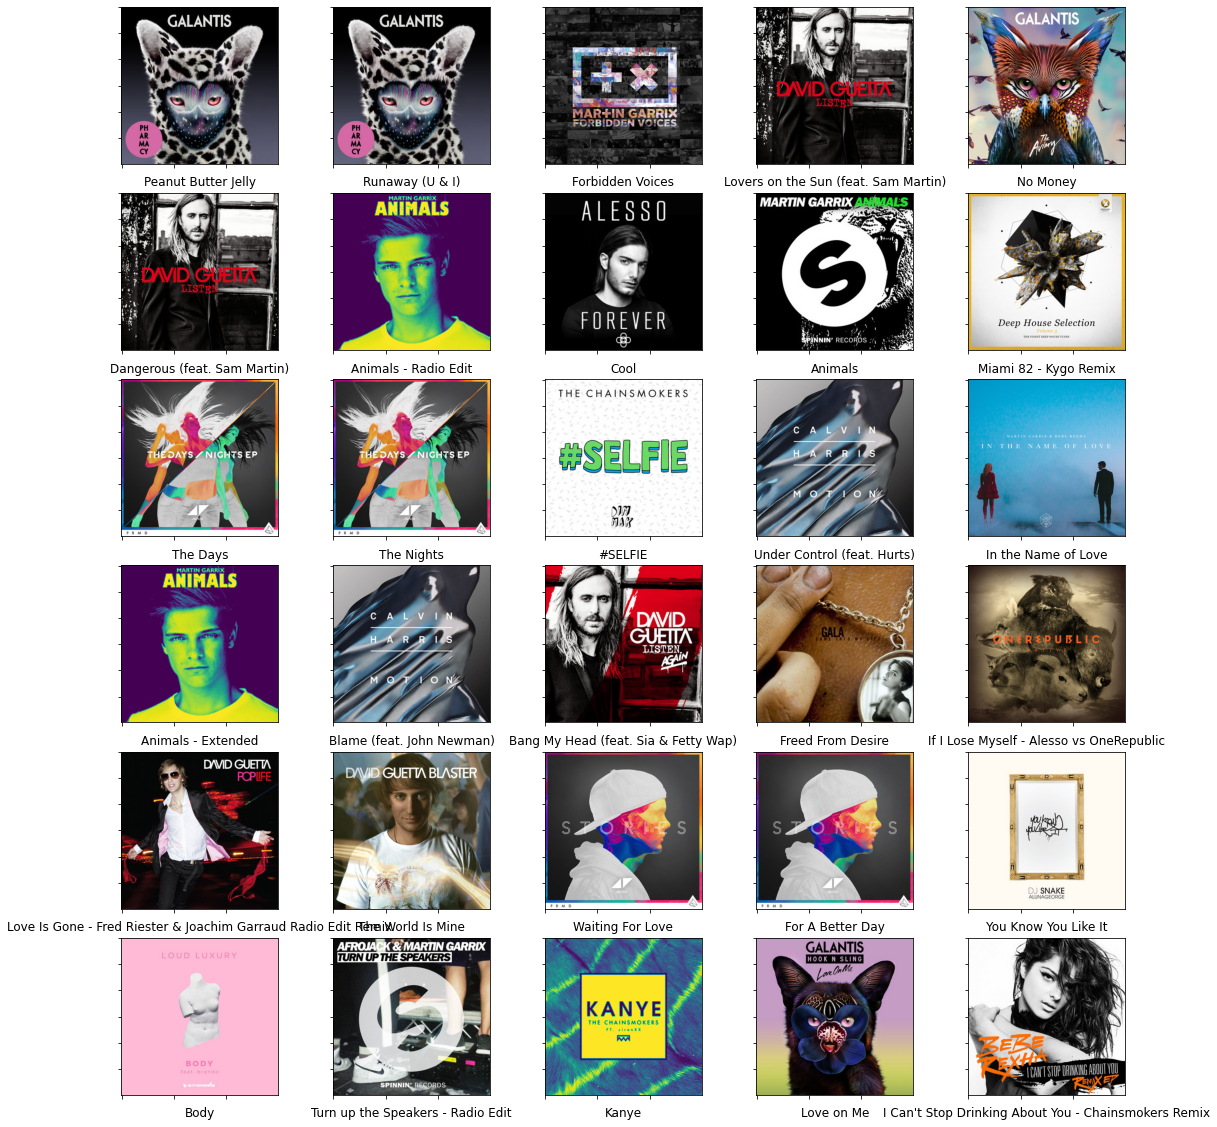

In [39]:
visualize_songs(test_top30)